<a href="https://colab.research.google.com/github/seawavve/PeekABook/blob/main/model/custom_bert_final5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Augumentation

In [1]:
! pip install numpy requests nlpaug

     |████████████████████████████████| 399kB 7.0MB/s 


# Setup

In [1]:
! pip install -q tensorflow-text
! pip install -q tf-models-official

     |████████████████████████████████| 4.3MB 31.4MB/s 
     |████████████████████████████████| 1.6MB 28.0MB/s 
     |████████████████████████████████| 51kB 8.3MB/s 
     |████████████████████████████████| 686kB 44.7MB/s 
     |████████████████████████████████| 1.2MB 47.9MB/s 
     |████████████████████████████████| 102kB 14.0MB/s 
     |████████████████████████████████| 38.2MB 79kB/s 
     |████████████████████████████████| 645kB 47.8MB/s 
     |████████████████████████████████| 358kB 59.6MB/s 
     |████████████████████████████████| 174kB 60.5MB/s 
     |████████████████████████████████| 61kB 8.7MB/s 


In [2]:
import os, sys 
from google.colab import drive 
drive.mount('/content/mnt') 
nb_path = '/content/notebooks' 
os.symlink('/content/mnt/My Drive/Colab Notebooks', nb_path) 
sys.path.insert(0, nb_path)


Mounted at /content/mnt


In [3]:
import os
import shutil
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
#@title Configure the model { run: "auto" }
BERT_MODEL = "https://tfhub.dev/google/experts/bert/wiki_books/sst2/2"
# Preprocessing must match the model, but all the above use the same.
PREPROCESS_MODEL = hub.load('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')

In [5]:
# data=pd.read_csv('./Peterpan_emo3.csv')
# data=data.dropna(how='any')
# print(f'Dimensions: {data.shape}')
# data

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 1
seed = 1

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'mnt/MyDrive/emo9_data/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'mnt/MyDrive/emo9_data/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'mnt/MyDrive/emo9_data/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 725 files belonging to 4 classes.
Using 580 files for training.
Found 725 files belonging to 4 classes.
Using 145 files for validation.
Found 120 files belonging to 4 classes.


In [7]:
for text_batch, label_batch in train_ds.take(3):
  print(f'Review: {text_batch.numpy()[0]}')
  label = label_batch.numpy()[0]
  print(f'Label : {label} ({class_names[label]})')
  text_test = [text_batch.numpy()[0]]
  text_preprocessed = PREPROCESS_MODEL(text_test)
  print(f'Keys       : {list(text_preprocessed.keys())}')
  print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
  print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
  print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
  print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}\n')
  


Review: b"And don't you dare let it burn, I want everything perfect on Duddy's birthday."
Label : 2 (2)
Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 1998 2123 1005 1056 2017 8108 2292 2009 6402 1010 1045]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]

Review: b"I told you but-ter wouldn't suit thiswatch, he add-ed with a scowl as he looked at the March Hare."
Label : 2 (2)
Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [  101  1045  2409  2017  2021  1011 28774  2876  1005  1056  4848  2023]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]

Review: b' As he had expected, Mrs. Dursley looked shocked and angry.'
Label : 2 (2)
Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2004 2002 2018 3517 1010 3680 1012 4241 2869 3051 2246]
Input Mask : [1 1 1 1 1 1 1 1 1 1 

# BERT

In [8]:
from tensorflow.keras import layers

def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(PREPROCESS_MODEL, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(BERT_MODEL, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']

  net = tf.keras.layers.Dropout(0.1)(net)
  #net = tf.keras.layers.Dense(64, activation='relu')(net)
  net = tf.keras.layers.Dense(4, activation='sigmoid', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [9]:
# classifier_model = build_classifier_model()
# bert_raw_result = classifier_model(tf.constant(text_test))
# print(tf.sigmoid(bert_raw_result))

In [10]:
text_test = ['this is such an amazing movie!']
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.66526103 0.6240653  0.5816965  0.5716621 ]], shape=(1, 4), dtype=float32)


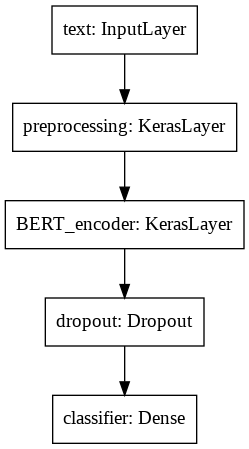

In [11]:
tf.keras.utils.plot_model(classifier_model)

In [12]:
! pip install -q tf-models-official
from official.nlp import optimization

In [13]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy()
epochs = 3
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')


In [14]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metric)

In [15]:
print(f'Training model with {BERT_MODEL}')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs,
                               callbacks=[es])

Training model with https://tfhub.dev/google/experts/bert/wiki_books/sst2/2
Epoch 1/3
580/580 [==============================] - 137s 211ms/step - loss: 1.5468 - sparse_categorical_accuracy: 0.5276 - val_loss: 1.3602 - val_sparse_categorical_accuracy: 0.6552
Epoch 2/3
580/580 [==============================] - 53s 91ms/step - loss: 0.8725 - sparse_categorical_accuracy: 0.7931 - val_loss: 1.8478 - val_sparse_categorical_accuracy: 0.6690
Epoch 3/3
580/580 [==============================] - 52s 90ms/step - loss: 0.2758 - sparse_categorical_accuracy: 0.9207 - val_loss: 2.1139 - val_sparse_categorical_accuracy: 0.6897


In [16]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

120/120 [==============================] - 20s 152ms/step - loss: 2.2897 - sparse_categorical_accuracy: 0.6583
Loss: 2.2896673679351807
Accuracy: 0.6583333611488342


dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


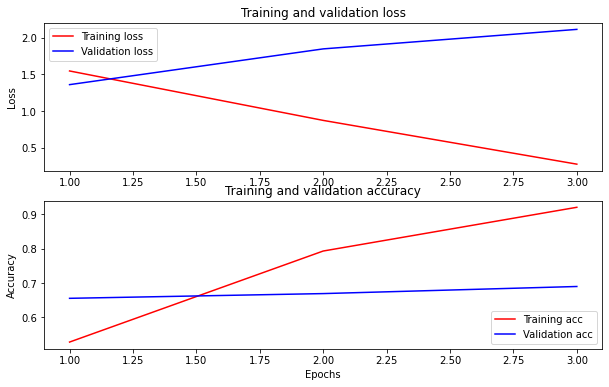

In [17]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['sparse_categorical_accuracy']
val_acc = history_dict['val_sparse_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [18]:
import numpy as np
predictions = classifier_model.predict(test_ds)
print(len(predictions))
print(predictions[0])
c=0
result_df=pd.DataFrame(columns=['sentence','mark','predicted_mark'])

for example in test_ds:
  #print('sentence:',example[0].numpy()[0])
  #print('mark:',example[1].numpy()[0],'predicted mark:',np.argmax(predictions[c]))
  result_df=result_df.append({'sentence':example[0].numpy()[0],
                              'mark':example[1].numpy()[0], 
                              'predicted_mark':np.argmax(predictions[c])},ignore_index=True)
  c+=1

#print(predictions)
display(result_df)
result_df.to_csv('./result.csv')

120
[0.01556185 0.2862018  0.9940823  0.19864938]


,sentence,mark,predicted_mark
0,"b'They and the Seven Dwarfs, lived long and ha...",1,2
1,b' Noureddin made all haste on his journey to ...,0,2
2,b'She would never let them copy How will you l...,0,0
3,"b' I smile with joy at seeing him still alive,...",3,3
4,"b"" At the foot of the grand-vizir's staircase ...",0,0
...,...,...,...
115,b' This kind maiden has rescued you from a ter...,1,1
116,b'nan',1,0
117,b'For the Mouse swam off from her as fast as i...,2,0
118,b' I could hear the shrieks and groans of the ...,3,3


In [19]:
# from sklearn.model_selection import GridSearchCV

# params = {'epochs':[10,20,30], 'learning_rate':[2e-5, 3e-5, 5e-5]}
# grid = GridSearchCV(estimator=classifier_model, param_grid=params, scoring='sparse_categorical_accuracy', n_jobs=-1, cv=3)
# grid_result = grid.fit(X, Y)

# # fit gridsearch 
# clf.fit(X_train ,y_train)